# Implementation of Softmax Regression from Scratch
Khai báo thư viện:


In [ ]:
!pip install d2l==0.15.1


In [ ]:
from d2l import tensorflow as d2l
import tensorflow as tf
from IPython import display

In [ ]:
# Khởi tạo kích thước batch là 256
batch_size = 256
# Lấy dữ liệu từ tập dữ liệu Fashion-MNIST với kích thước batch là 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


## Initializing Model Parameters

Mỗi example là một tấm ảnh có kích thước 28 x 28 với 784 điểm ảnh được biểu diễn bằng một vector có độ dài là 784. Mỗi điểm ảnh là một đặc trưng.

Do tập dữ liệu có 10 lớp, ta có số lượng đầu ra là 10. Như vậy, ta có ma trận weight có kích thước $784 \times 10$ và vector bias có kích thước $1 \times 10$. Ta sẽ khởi tạo `W` với nhiễu Gaussian và bias có giá trị khởi tạo là 0.


In [ ]:
# Xem một tấm ảnh 28x28 có 784 điểm ảnh là 1 vector. Mỗi điểm ảnh là một đặc trưng 
num_inputs = 784
# Số lượng output là số lớp của tập dữ liệu có sẵn
num_outputs = 10
# Khởi tạo biến ma trận weight có kích thước 784 x 10 với các giá trị được tạo ngẫu nhiên từ phân phối chuẩn có mean = 0 và stdev = 0.01
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs),mean=0, stddev=0.01))
# Khởi tạo biến vector bias có kích thước 1 x 10 với giá trị khởi tạo là 0
b = tf.Variable(tf.zeros(num_outputs))

## Defining the Softmax Operation



Softmax được tính theo công thức:

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

Để tránh số quá lớn sẽ gây tràn số và khó khăn trong việc tính toán, ta tối ưu lại hàm softmax bằng cách trừ đi phần tử lớn nhất trong hàng rồi tính exp.

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij} - max(\mathbf{X}_{i}))}{\sum_k \exp(\mathbf{X}_{ik} - max(\mathbf{X}_{i}))}.
$$

In [ ]:
def softmax(X):
    # Tính e^(X - max(X))
    X_exp = tf.exp(X - tf.math.reduce_max(X, axis = 1, keepdims = True))
    # Tính tổng e^(X -max(X)) của các hàng và giữ nguyên số chiều
    partition = tf.reduce_sum(X_exp, axis = 1, keepdims = True)
    # Trả về softmax của X
    return X_exp / partition

## Defining the Model

Ta chuyển các hình ảnh có kích thước 28x28 thành một vector có kích thước 784. Như vậy, ma trận inputs X có kích thước 256x784. Ma trận W có kích thước 784x10. Lấy XW + b ta được Y_hat tương ứng.

In [ ]:
def net(X):
    # Chuyển các inputs thành vector rồi đem nhân với Weight và cộng với bias và trả về softmax(XW + b)
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

## Defining the Loss Function

Ta sử dụng cross entropy dùng làm hàm loss cho softmax regression. Cross entropy chính là negative log-likelihood của xác suất dự đoán đúng.



In [ ]:
def cross_entropy(y_hat, y):
    # Tìm one hot encoding của y_hat dựa trên y, sau đó áp one hot encoding vào y_hat rồi tính -log
    return -tf.math.log(tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

## Classification Accuracy

Với phân phối xác suất dự đoán `y_hat`, ta thường chọn lớp có xác suất dự đoán cao nhất khi phải đưa ra một dự đoán cụ thể.

Các dự đoán là chính xác nếu như `y_hat` trùng khớp với `y`. Độ chính xác phân loại chính là số lượng dự đoán đúng / số lượng dự đoán.

Để tính toán độ chính xác:
* Nếu `y_hat` là ma trận, ta giả sử chiều thứ 2 chứa giá trị dự đoán cho mỗi class. Ta dùng `argmax(axis = 1)` để xác định được vị trí chứa giá trị lớn nhất trong mỗi hàng.
* Chuyển `y_hat` sang dạng của `y` để so sánh. Kết quả sẽ là True / False
* Sau đó chuyển kết quả sang dạng 0 và 1. Tính tổng tất cả kết quả ta sẽ tính được số lượng dự đoán đúng.


In [ ]:
# Tính số lượng dự đoán đúng 
def accuracy(y_hat, y):
    # Nếu y_hat là một ma trận và có chiều thứ 2 có nhiều hơn 1 class thì 
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # y_hat chính là chỉ số của class đầu ra có giá trị lớn nhất
        y_hat = tf.argmax(y_hat, axis=1)
    # Chuyển y_hat sang dạng của y để so sánh      
    cmp = tf.cast(y_hat, y.dtype) == y
    # Trả về kết quả là số lượng kết quả dự đoán đúng
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

In [ ]:
# Tính tổng của tích luỹ của nhiều biến
class Accumulator:
    # Constructor với 1 tham số là số lượng biến lưu trữ
    def __init__(self, n):
        self.data = [0.0] * n

    # Method này dùng để thêm dữ liệu của các tham số truyền vào vào trong biến lưu trữ
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    # Method này dùng để xoá dữ liệu của các biến lưu trữ
    def reset(self):
        self.data = [0.0] * len(self.data)

    # Method này dùng để trả về giá trị của biến lưu trữ tương ứng
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# Tính toán độ chính xác của một mô hình trên một tập dữ liệu
def evaluate_accuracy(net, data_iter):
    # Khởi tạo 2 biến là tổng số dự đoán đúng và tổng số dự đoán lưu trong data của Accumulator
    metric = Accumulator(2)
    # Với mỗi bộ inputs và outputs của dữ liệu
    for X, y in data_iter:
        # Thêm số lượng dự đoán đúng và số lượng dự đoán của bộ dữ liệu
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    # Trả về độ chính xác của mô hình chính là số lượng dự đoán đúng / số lượng dự đoán
    return metric[0] / metric[1]


Do ta khởi tạo model với weights ngẫu nhiên nên độ chính xác của model sẽ gần với dự đoán ngẫu nhiên tức là 0.1 với 10 lớp. 


## Training



In [ ]:
# Cập nhật giá trị tham số sử dụng minibatch stochastic gradient descent 
class Updater():
    # Constructor với 2 tham số đó là danh sách tham số và learning rate 
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr
    # Method __call__ dùng để cập nhật tham số bằng sgd khi gọi tới
    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

In [ ]:
def train_epoch(net, train_iter, loss, updater):
    # Khởi tạo Accumulator lưu trữ 3 giá trị: tổng mất mát, tổng số dự đoán đúng và số lượng mẫu
    metric = Accumulator(3)
    for X, y in train_iter:
        with tf.GradientTape() as g:
            # Tính toán giá trị dự đoán mô hình
            y_hat = net(X)
            l = loss(y_hat, y)
        # Tính gradient của loss theo params của updater và cập nhật giá trị params
        updater(X.shape[0], g.gradient(l, updater.params))
        # Tính tổng loss
        l_sum = tf.reduce_sum(l)
        # Cập nhật giá trị tổng loss, tổng số dự đoán đúng và số lượng mẫu
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Trả về training loss và training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
# Mô hình hoá dữ liệu với hình động
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        # Sử dụng định dạng svg để vẽ đồ thị
        d2l.use_svg_display()
        # Cài đặt subplot
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Thêm nhiều điểm dữ liệu vào hình
        # Nếu y chỉ có 1 tham số truyền vào thì chuyển y sang list để tìm len
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        # Nếu x chỉ có 1 tham số truyền vào thì số lượng x tương ứng số lượng y
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # Hiển thị hình vẽ
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
# Train model
def train(net, train_iter, test_iter, loss, num_epochs, updater):
    # Khởi tạo animator để mô hình hoá
    animator = Animator(xlabel='Epoch', xlim=[1, num_epochs], ylim=[0, 1],legend=['train loss', 'train acc', 'test acc'])
    # Lặp num_epochs lần
    for epoch in range(num_epochs):
        # Train từng epoch
        train_metrics = train_epoch(net, train_iter, loss, updater)
        # Tính độ chính xác của mô hình trên tập test
        test_acc = evaluate_accuracy(net, test_iter)
        # Thêm dữ liệu gồm train loss, train acc và test acc của mỗi epoch vào đồ thị
        animator.add(epoch + 1, train_metrics + (test_acc,))

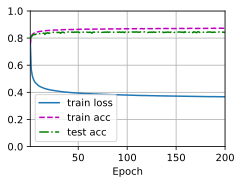

In [ ]:
# Khởi tạo updater với params là W, b và learning rate là 0.1
updater = Updater([W, b], lr=0.1)
# Số lần chạy
num_epochs = 200
# Train model và in ra animation cho mỗi epoch
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## Prediction

Sau khi train xong, ta thử phân loại hình ảnh. Dòng trên là label đúng, dòng dưới là label mô hình dự đoán.


In [41]:
import random
# Dự đoán labels 
def predict_test(net, test_iter, n=8):
    # Test với tập dữ liệu đầu tiên
    for X, y in test_iter:
        break
    # Lấy text label của label đúng từ tập dữ liệu
    trues = d2l.get_fashion_mnist_labels(y)
    # Lấy text label của label dự đoán
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    # Label để in ra
    titles = ['T: '+ true + '\n' + 'P: ' + pred for true, pred in zip(trues, preds)]
    # Random vị trí ảnh trong bộ test
    rand = random.randint(0,batch_size - n)
    # In ra n ảnh tương ứng
    d2l.show_images(tf.reshape(X[rand:rand+n], (n, 28, 28)), 1, n, titles=titles[rand:rand+n])

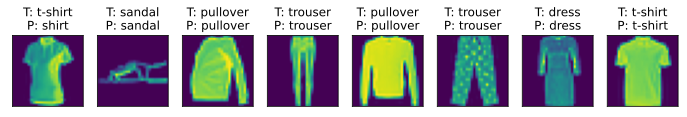

In [44]:
num_images = 8
predict_test(net, test_iter, num_images)